<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x04_%E5%9B%BE%E5%83%8F%E5%88%86%E7%B1%BB%E6%95%B0%E6%8D%AE%E9%9B%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

softmax回归跟线性回归一样将输入特征与权重做线性叠加。与线性回归的一个主要不同在于，softmax回归的输出值个数等于标签里的类别数。因为一共有4种特征和3种输出动物类别，所以权重包含12个标量（带下标的ww）、偏差包含3个标量（带下标的bb），且对每个输入计算o1,o2,o3 这3个输出：
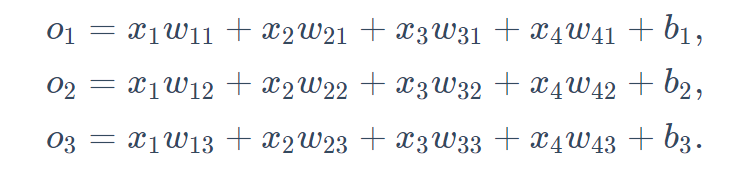

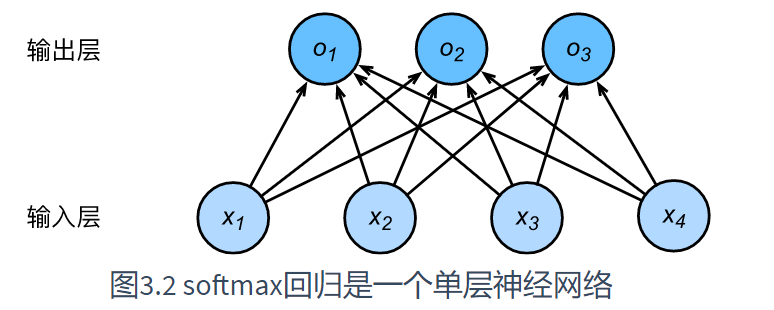

## 0.图像分类数据集

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys
from IPython import display
%matplotlib inline

下面，我们通过torchvision的torchvision.datasets来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数train来指定获取训练数据集或测试数据集（testing data set）。测试数据集也叫测试集（testing set），只用来评价模型的表现，并不用来训练模型。

另外我们还指定了参数transform = transforms.ToTensor()使所有数据转换为Tensor，如果不进行转换则返回的是PIL图片。transforms.ToTensor()将尺寸为 (H x W x C) 且数据位于[0, 255]的PIL图片或者数据类型为np.uint8的NumPy数组转换为尺寸为(C x H x W)且数据类型为torch.float32且位于[0.0, 1.0]的Tensor。

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
print(type(mnist_train))
print(len(mnist_train),len(mnist_test))

torchvision.datasets.mnist.FashionMNIST
60000 10000


In [4]:
feature, label = mnist_train[0]
print(feature.shape, label)  # Channel x Height x Width


torch.Size([1, 28, 28]) 9


变量feature对应高和宽均为28像素的图像。由于我们使用了transforms.ToTensor()，所以每个像素的数值为[0.0, 1.0]的32位浮点数。需要注意的是，feature的尺寸是 (C x H x W) 的，而不是 (H x W x C)。第一维是通道数，因为数据集中是灰度图像，所以通道数为1。后面两维分别是图像的高和宽。

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签

In [5]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

下面定义一个可以在一行里画出多张图像和对应标签的函数。

In [6]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()


In [7]:

def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()


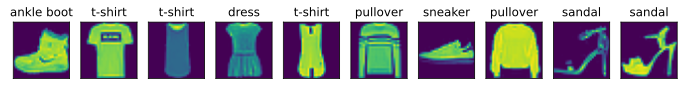

In [8]:
X,y = [],[]
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X,get_fashion_mnist_labels(y))

读取小批量

In [13]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0 # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=False,num_workers=num_workers)

最后我们查看读取一遍训练数据需要的时间。

In [15]:
start = time.time()
for X,y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

4.61 sec


## 小结
Fashion-MNIST是一个10类服饰分类数据集，之后章节里将使用它来检验不同算法的表现。
我们将高和宽分别为hh和ww像素的图像的形状记为h×wh×w或(h，w)。